## Import the necessary libraries 

In [5]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 

import tensorflow as tf 
import pickle
from tensorflow.keras.models import load_model
from keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
from keras.optimizers import SGD





## Cheik the versions 

In [6]:
# Python version
print('Python version: {}'.format(sys.version))

# numpy 
print('numpy version: {}'.format(np.__version__))

# pandas 
print('pandas version: {}'.format(pd.__version__))

# matplotlib 
import matplotlib; print('matplotlib version: {}'.format(matplotlib.__version__))

# torch 
print('torch version: {}'.format(torch.__version__))

# scikit-learn 
import sklearn; print('sklearn version: {}'.format(sklearn.__version__)) 

# tensorflow 
print('tensorflow version: {}'.format(tf.__version__))

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
numpy version: 1.18.1
pandas version: 1.0.3
matplotlib version: 3.2.1
torch version: 1.5.0
sklearn version: 0.22.2.post1
tensorflow version: 2.1.0


## Paths and lengths 

In [7]:
# Root directory for dataset
path_root = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
path_train= '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
path_test = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
path_val  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'



In [8]:
XRay_normal = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg')
XRay_bacteria = glob.glob('/kaggle/input/preuni/Bacteria/Bacteria/*.jpeg')
XRay_virus = glob.glob('/kaggle/input/preuni/Virus/Virus/*.jpeg')


In [9]:
len(XRay_normal)

1341

## Compute the time 

In [10]:
# Time 
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

## Take a quick look at of the images 

## Get data 

In [11]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []         
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. #for formalizing to [-1,1] ==> (imgs_data - 127.5)/127.5 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        imgs_data = imgs_data[idx,:,:,:] 
    
    print(f"Hey! the calculations are done in {_time(start, time.time())}")
    return imgs_data  


In [12]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(XRay_normal)
print()
print('Starting for BATERIA X-Ray images ...')
X_BATERIA = get_data(XRay_bacteria)


Starting for NORMAL X-Ray images ...
Processing index 00000 of 01341 ==> 000%
Processing index 00134 of 01341 ==> 010%
Processing index 00268 of 01341 ==> 020%
Processing index 00402 of 01341 ==> 030%
Processing index 00536 of 01341 ==> 040%
Processing index 00670 of 01341 ==> 050%
Processing index 00804 of 01341 ==> 060%
Processing index 00938 of 01341 ==> 070%
Processing index 01072 of 01341 ==> 080%
Processing index 01206 of 01341 ==> 090%
Processing index 01340 of 01341 ==> 100%
Hey! the calculations are done in 1min 6.3sec

Starting for BATERIA X-Ray images ...
Processing index 00000 of 02530 ==> 000%
Processing index 00253 of 02530 ==> 010%
Processing index 00506 of 02530 ==> 020%
Processing index 00759 of 02530 ==> 030%
Processing index 01012 of 02530 ==> 040%
Processing index 01265 of 02530 ==> 050%
Processing index 01518 of 02530 ==> 060%
Processing index 01771 of 02530 ==> 070%
Processing index 02024 of 02530 ==> 080%
Processing index 02277 of 02530 ==> 090%
Hey! the calculat

In [13]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    # save the started time 
    start = time.time() 
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_bateria = define_grid(X_BATERIA, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.12sec
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.12sec


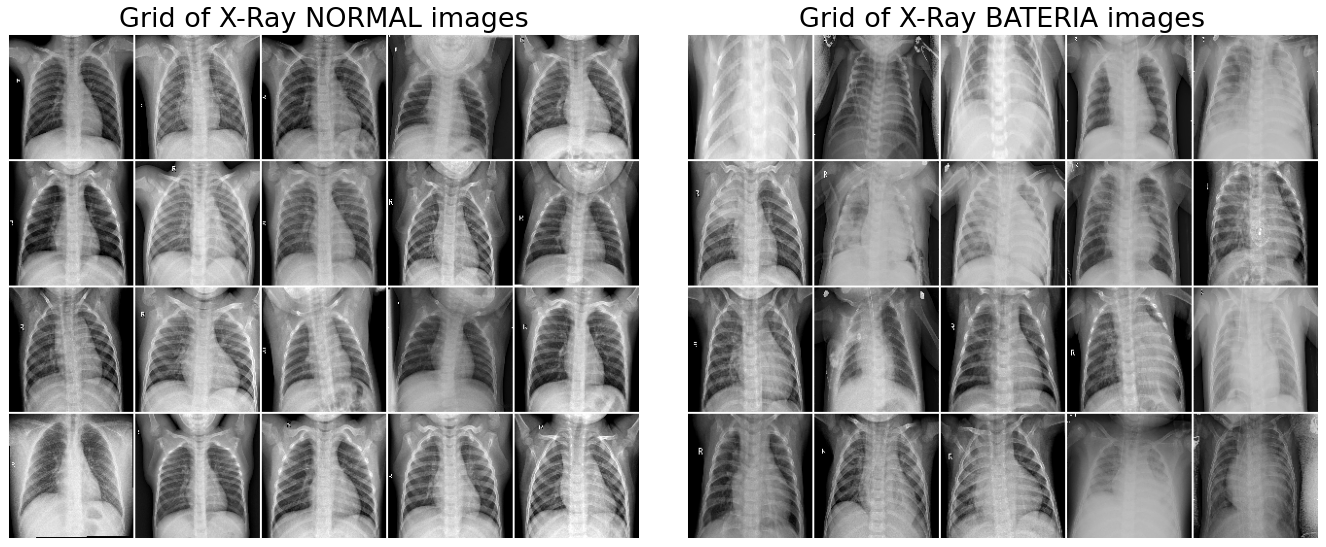

In [14]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

ax2.imshow(grid_X_bateria); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray BATERIA images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

## Set the parameters  

In [15]:
# Number of images to use (will be changed)
#n_images = 12_000 

# Number of training epochs
n_epoch = 200

# Batch size during training 
batch_size = 128 

# Size of z latent vector (i.e. size of generator input) 
latent_dim = 100 

# Spatial size of training images. All images will be resized to this size 
cols, rows = 128, 128 

# Number of channels in the training images. For RGB color images this is 3
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4


# Discriminator 

In [16]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential()
    
    # 128x128 -> 64x64
    model.add(layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # 64x64 -> 32x32
    model.add(layers.Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # 32x32 -> 16x16
    model.add(layers.Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 16x16 -> 8x8
    model.add(layers.Conv2D(512, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

## Generator 

In [17]:
def define_generator(latent_dim):
    model = models.Sequential()
    
    # Foundation for 8x8 feature maps
    n_nodes = 256 * 8 * 8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((8, 8, 256)))  # Tăng số filters
    
    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Upsample to 128x128
    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Output layer
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))  # RGB
    model.summary()
    return model
#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN model 

In [18]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)  
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

# Train the models 

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):

    os.makedirs('models', exist_ok=True)
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%10 == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            g_model.save(f'models/generator_epoch_{i+1}.h5')
            d_model.save(f'models/discriminator_epoch_{i+1}.h5')
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss)

In [ ]:
normal_discriminator = define_discriminator() 
normal_generator = define_generator(latent_dim) 

In [28]:
normal_discriminator = define_discriminator() 
normal_generator = define_generator(latent_dim) 

# create the gan 
normal_gan = define_gan(normal_generator, normal_discriminator)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)      

Training Start...
Epoch: 001/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.019], time: 5.1sec
Epoch: 002/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.013], time: 5.07sec
Epoch: 003/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.011], time: 5.07sec
Epoch: 004/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.009], time: 5.07sec
Epoch: 005/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.010], time: 5.07sec
Epoch: 006/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.009], time: 5.06sec
Epoch: 007/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.009], time: 5.06sec
Epoch: 008/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.008], time: 5.07sec
Epoch: 009/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.007], time: 5.07sec
Epoch: 010/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.008], time: 5.07sec
> Accuracy at epoch 10 [real: 100%, fake: 100%]


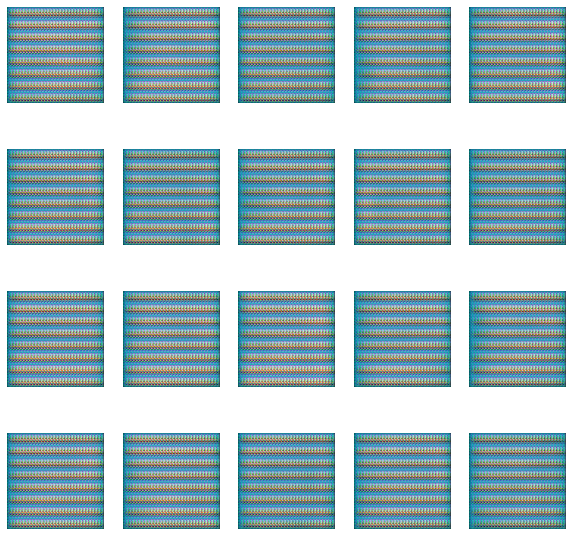

Epoch: 011/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.008], time: 5.07sec
Epoch: 012/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.011], time: 5.07sec
Epoch: 013/200, Loss: [D_real = 0.000, D_fake = 0.000, G = 0.014], time: 5.07sec
Epoch: 014/200, Loss: [D_real = 0.001, D_fake = 0.000, G = 0.039], time: 5.07sec
Epoch: 015/200, Loss: [D_real = 0.005, D_fake = 0.043, G = 47.814], time: 5.07sec
Epoch: 016/200, Loss: [D_real = 0.001, D_fake = 0.104, G = 16.355], time: 5.07sec
Epoch: 017/200, Loss: [D_real = 0.098, D_fake = 0.013, G = 1.863], time: 5.07sec
Epoch: 018/200, Loss: [D_real = 0.036, D_fake = 0.026, G = 0.820], time: 5.07sec
Epoch: 019/200, Loss: [D_real = 0.091, D_fake = 0.056, G = 0.332], time: 5.07sec
Epoch: 020/200, Loss: [D_real = 0.053, D_fake = 0.025, G = 0.050], time: 5.07sec
> Accuracy at epoch 20 [real: 100%, fake: 100%]


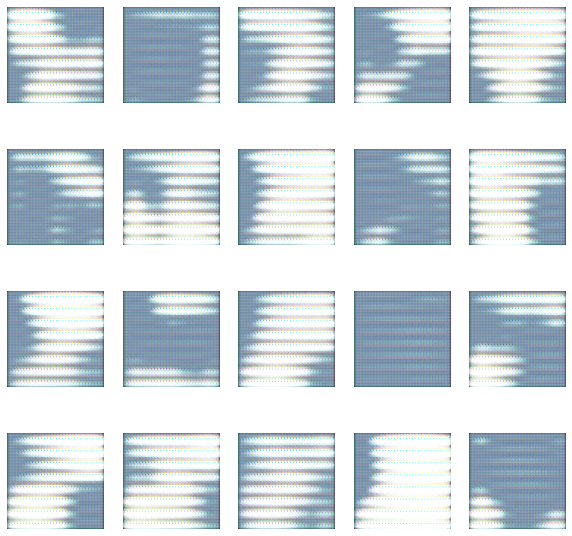

Epoch: 021/200, Loss: [D_real = 0.025, D_fake = 0.023, G = 0.028], time: 5.07sec
Epoch: 022/200, Loss: [D_real = 0.034, D_fake = 0.018, G = 0.005], time: 5.07sec
Epoch: 023/200, Loss: [D_real = 0.109, D_fake = 0.052, G = 0.013], time: 5.07sec
Epoch: 024/200, Loss: [D_real = 0.047, D_fake = 0.093, G = 0.035], time: 5.07sec
Epoch: 025/200, Loss: [D_real = 0.040, D_fake = 0.028, G = 0.008], time: 5.07sec
Epoch: 026/200, Loss: [D_real = 0.213, D_fake = 0.131, G = 0.149], time: 5.07sec
Epoch: 027/200, Loss: [D_real = 0.041, D_fake = 0.063, G = 0.022], time: 5.08sec
Epoch: 028/200, Loss: [D_real = 0.053, D_fake = 0.029, G = 0.022], time: 5.08sec
Epoch: 029/200, Loss: [D_real = 0.121, D_fake = 0.020, G = 0.006], time: 5.08sec
Epoch: 030/200, Loss: [D_real = 0.020, D_fake = 0.010, G = 0.019], time: 5.07sec
> Accuracy at epoch 30 [real: 100%, fake: 100%]


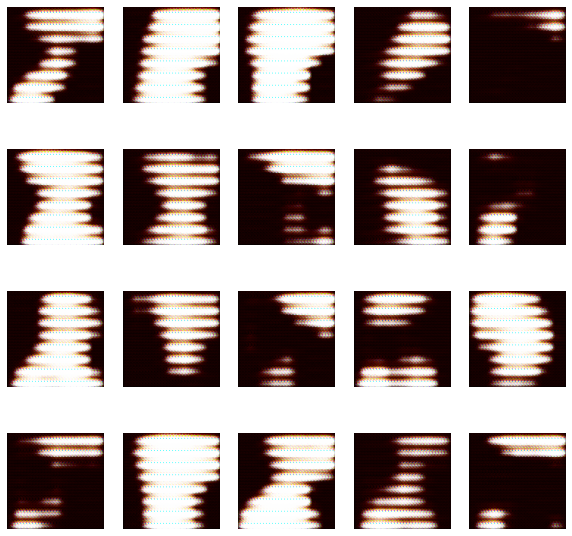

Epoch: 031/200, Loss: [D_real = 0.010, D_fake = 0.011, G = 0.014], time: 5.07sec
Epoch: 032/200, Loss: [D_real = 0.017, D_fake = 0.011, G = 0.005], time: 5.07sec
Epoch: 033/200, Loss: [D_real = 0.005, D_fake = 0.005, G = 0.009], time: 5.07sec
Epoch: 034/200, Loss: [D_real = 0.004, D_fake = 0.004, G = 0.002], time: 5.07sec
Epoch: 035/200, Loss: [D_real = 0.007, D_fake = 0.009, G = 0.002], time: 5.07sec
Epoch: 036/200, Loss: [D_real = 0.004, D_fake = 0.004, G = 0.021], time: 5.07sec
Epoch: 037/200, Loss: [D_real = 0.004, D_fake = 0.004, G = 0.001], time: 5.07sec
Epoch: 038/200, Loss: [D_real = 0.007, D_fake = 0.001, G = 0.005], time: 5.07sec
Epoch: 039/200, Loss: [D_real = 0.004, D_fake = 0.004, G = 0.002], time: 5.08sec
Epoch: 040/200, Loss: [D_real = 0.005, D_fake = 0.003, G = 0.003], time: 5.07sec
> Accuracy at epoch 40 [real: 100%, fake: 100%]


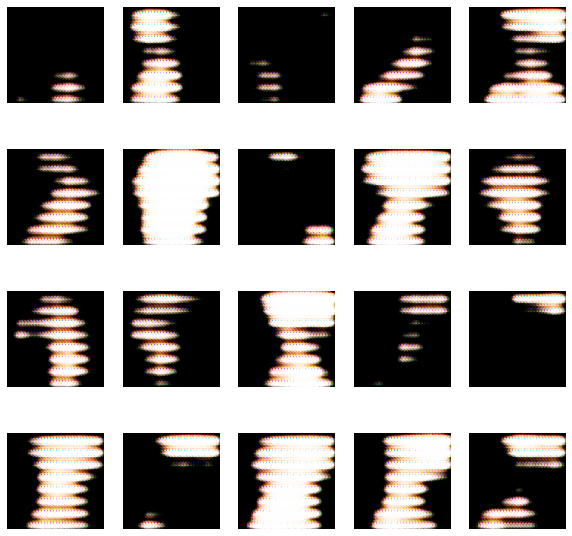

Epoch: 041/200, Loss: [D_real = 0.003, D_fake = 0.002, G = 0.006], time: 5.07sec
Epoch: 042/200, Loss: [D_real = 0.006, D_fake = 0.004, G = 0.008], time: 5.07sec
Epoch: 043/200, Loss: [D_real = 0.003, D_fake = 0.007, G = 0.004], time: 5.07sec
Epoch: 044/200, Loss: [D_real = 0.004, D_fake = 0.005, G = 0.024], time: 5.06sec
Epoch: 045/200, Loss: [D_real = 0.004, D_fake = 0.001, G = 0.042], time: 5.07sec
Epoch: 046/200, Loss: [D_real = 0.002, D_fake = 0.002, G = 0.003], time: 5.06sec
Epoch: 047/200, Loss: [D_real = 0.002, D_fake = 0.002, G = 0.038], time: 5.07sec


In [ ]:
train(normal_generator, normal_discriminator, normal_gan, X_normal, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [ ]:
bacteria_discriminator = define_discriminator() 
bacteria_generator = define_generator(latent_dim) 

# create the gan 
bacteria_gan = define_gan(bacteria_generator, bacteria_discriminator)

In [ ]:
# train model 
train(bacteria_generator, bacteria_discriminator, bacteria_gan, X_bacteria, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [ ]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model=bacteria_generator, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(bacteria_generator, n_samples=20)

## Generated and save the images in a zippez file 

In [ ]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('../working/XRayNormalFakeBacteria_check.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=1000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()

In [ ]:
!zip -r /kaggle/working/model_bacteria.zip /kaggle/working/models


In [ ]:
!zip -r /kaggle/working/pic_bacteria.zip /kaggle/working/*.png


In [ ]:
virus_discriminator = define_discriminator() 
virus_generator = define_generator(latent_dim) 

# create the gan 
virus_gan = define_gan(virus_generator, virus_discriminator)

In [ ]:
train(virus_generator, virus_discriminator, virus_gan, X_virus, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [13]:

model_400=load_model('/kaggle/input/model_epochs_450/keras/default/1/kaggle/working/models/generator_epoch_400.h5')


In [14]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(model_400, n_samples=20)

In [18]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('../working/XRayNormalFakenormal_check450_10000sample.zip', mode='w')

XRay_generated = XRayFakeGenerator(model_400,n_samples=10000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()

In [ ]:
!zip -r /kaggle/working/model_normal.zip /kaggle/working/models

In [ ]:
!zip -r /kaggle/working/pic_normal.zip /kaggle/working/*.png

In [ ]:
from IPython.display import FileLink, display

print("👉 Tải file model_normal.zip:")
display(FileLink('/kaggle/working/model_normal.zip'))

print("👉 Tải file pic_normal.zip:")
display(FileLink('/kaggle/working/pic_normal.zip'))